In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import scipy.integrate

import subprocess

# Collimator Effectiveness

In [2]:
dataDir = '../../geant/data/collimator1/'
dataFileBase = 'output'

nParticles = 100000

In [214]:
# Calculate surface fluxes
radius = 1
while radius <= 20:
    file = dataDir + dataFileBase + '_' + '{:.6f}'.format(radius / 4) + '_' + str(nParticles) + '.root'
    
    # This is a hilariously slow way to do this tbh, but this is how to suppress error messages
    # For some reason although this notebook is running under root environment, CLING seems to
    # not be able to find libraries/header files. Activating the conda env for every single call
    # is stupidly slow but it works with relatively negligible overhead, so... - Lars
    #subprocess.run('. $CONDA_PREFIX/etc/profile.d/conda.sh; conda activate cern_root; ../build/DetectorSurfaceCounts ' + file, shell=True)
    subprocess.run('../build/DetectorSurfaceFlux ' + file, shell=True)
    
    radius += 1

In [176]:
# Extract data from post analysis root file now

radius = 6

file = dataDir + dataFileBase + '_' + '{:.6f}'.format(radius / 4) + '_' + str(nParticles) + '_flux.root'
file = uproot.open(file)

data = file['Entering Flux']['neutron']['posz'].arrays(library='pd')

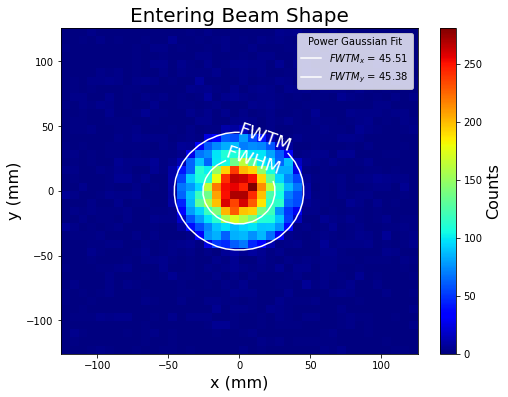

Roughly 51.9% of beam counts are in FWHM
Roughly 94.4% of beam counts are in FWTM


In [178]:
fig, ax = plt.subplots(figsize=(8, 6))

(z, x, y, img) = ax.hist2d(data['coord1'], data['coord2'], bins=40, cmap=plt.cm.jet)

# Average the left and right values for each hist bin
x = np.convolve(x, np.ones(2)/2, mode='valid')
y = np.convolve(y, np.ones(2)/2, mode='valid')
""
# Fit the histogram using a Power Gaussian

# Don't use this function except in this cell really, it is terrible
def GaussFit2DArr(r, amplitude, sigma_x, sigma_y, mu_x, mu_y, offset, power):
    x = r - np.array([[mu_x], [mu_y]])
    
    # inverse of covariance matrix
    sigma = [[1 / (sigma_x ** 2), 0], [0, 1 / (sigma_y ** 2)]]
    
    return offset + amplitude * np.exp(- (0.5 * np.transpose(x, (0, 2, 1)) @ (sigma @ x)).ravel() ** power)

r = np.array(np.meshgrid(x, y)).T.reshape((-1, 2, 1))

bounds = ([0, 0, 0, -np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
popt, pcov = scipy.optimize.curve_fit(GaussFit2DArr, r, z.ravel(), p0=(500, 20, 20, 0, 0, z[0, 0], 1), bounds=bounds)

fit = GaussFit2DArr(r, *popt).reshape(x.shape[0], -1)

CS = ax.contour(x, y, fit, levels=[popt[0] / 10 + popt[5], popt[0] / 2 + popt[5]],colors='w')

ax.clabel(CS, CS.levels, inline=True, fmt={CS.levels[0] : "FWTM", CS.levels[1] : "FWHM"}, fontsize=18)

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel('Counts', fontsize=16)

ax.set_xlabel('x (mm)', fontsize=16)
ax.set_ylabel('y (mm)', fontsize=16)
ax.set_title('Entering Beam Shape', fontsize=20)

fwhmWidthX = (np.max(CS.allsegs[1][0][:,0]) - np.min(CS.allsegs[1][0][:,0])) / 2
fwtmWidthX = (np.max(CS.allsegs[0][0][:,0]) - np.min(CS.allsegs[0][0][:,0])) / 2
fwhmWidthY = (np.max(CS.allsegs[1][0][:,1]) - np.min(CS.allsegs[1][0][:,1])) / 2
fwtmWidthY = (np.max(CS.allsegs[0][0][:,1]) - np.min(CS.allsegs[0][0][:,1])) / 2

# Dummy plot to add a legend label
ax.plot(0, 0, "-", c='w', label='$FWTM_x$ = %.2f' % (fwtmWidthX))
ax.plot(0, 0, "-", c='w', label='$FWTM_y$ = %.2f' % (fwtmWidthY))

ax.legend(title="Power Gaussian Fit")

plt.show()

# Calculate how much of "beam" is inside FWHM and FWTM
background = popt[5]
totalCounts = np.sum(z)
realTotalCounts = totalCounts - background * x.shape[0] ** 2
fwhmCounts = 0
fwtmCounts = 0

for pos, count in zip(np.array(np.meshgrid(x, y)).T.reshape((-1, 2)), z.ravel()):
    dist2 = (pos[0] - popt[3]) ** 2 / fwhmWidthX ** 2 + (pos[1] - popt[4]) ** 2 / fwhmWidthY ** 2
    if (dist2 < 1):
        fwhmCounts += (count - background)
        
    dist2 = (pos[0] - popt[3]) ** 2 / fwtmWidthX ** 2 + (pos[1] - popt[4]) ** 2 / fwtmWidthY ** 2
    if (dist2 < 1):
        fwtmCounts += (count - background)
        
fwhmPortion = fwhmCounts / realTotalCounts
fwtmPortion = fwtmCounts / realTotalCounts
print("Roughly %2.1f%% of beam counts are in FWHM" % (fwhmPortion * 100))
print("Roughly %2.1f%% of beam counts are in FWTM" % (fwtmPortion * 100))

In [179]:
fwhmList = []
efwhmList = []
fwtmList = []
efwtmList = []
fw100mList = []
efw100mList = []
radii = []

radius = 1
while radius <= 8:
    file = dataDir + dataFileBase + '_' + '{:.6f}'.format(radius / 4) + '_' + str(nParticles) + '_flux.root'
    file = uproot.open(file)
    
    data = file['Entering Flux']['neutron']['posz'].arrays(library='np')
    
    (z, x, y, img) = ax.hist2d(data['coord1'], data['coord2'], bins=50, cmap=plt.cm.jet)
    
    # Average the left and right values for each hist bin
    x = np.convolve(x, np.ones(2)/2, mode='valid')
    y = np.convolve(y, np.ones(2)/2, mode='valid')
    ""
    # Fit the histogram using Gaussian
    
    # Don't use this function except in this cell really, it is terrible
    def GaussFit2DArr(r, amplitude, sigma_x, sigma_y, mu_x, mu_y, offset, power):
        x = r - np.array([[mu_x], [mu_y]])
        
        # inverse of covariance matrix
        sigma = [[1 / (sigma_x ** 2), 0], [0, 1 / (sigma_y ** 2)]]
        
        return offset + amplitude * np.exp(- (np.transpose(x, (0, 2, 1)) @ (sigma @ x)).ravel() ** power)
    
    r = np.array(np.meshgrid(x, y)).T.reshape((-1, 2, 1))
    
    bounds = ([0, 0, 0, -np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    popt, pcov = scipy.optimize.curve_fit(GaussFit2DArr, r, z.ravel(), p0=(500, 20, 20, 0, 0, z[0, 0], 1), bounds=bounds)
    
    # Assuming everything is nicely cylindrically symmetrical
    sigma = (popt[1] + popt[2]) / 2
    power = popt[6]
    
    fwhmList.append(sigma * np.sqrt(2) * (np.log(2)) ** (1 / (2 * power)))
    fwtmList.append(sigma * np.sqrt(2) * (np.log(10)) ** (1 / (2 * power)))
    fw100mList.append(sigma * np.sqrt(2) * (np.log(100)) ** (1 / (2 * power)))
    
    cov_mat = pcov[np.ix_([1,6], [1,6])]
    grad_vec_h = np.array([1, -sigma / (2 * power ** 2) * np.log(np.log(2))]) * np.sqrt(2) * (np.log(2)) ** (1 / (2 * power))
    grad_vec_t = np.array([1, -sigma / (2 * power ** 2) * np.log(np.log(10))]) * np.sqrt(2) * (np.log(10)) ** (1 / (2 * power))
    grad_vec_100 = np.array([1, -sigma / (2 * power ** 2) * np.log(np.log(100))]) * np.sqrt(2) * (np.log(100)) ** (1 / (2 * power))
    
    efwhmList.append(np.sqrt(cov_mat @ grad_vec_h @ grad_vec_h))
    efwtmList.append(np.sqrt(cov_mat @ grad_vec_t @ grad_vec_t))
    efw100mList.append(np.sqrt(cov_mat @ grad_vec_100 @ grad_vec_100))
    
    radii.append(radius / 4)
    
    radius += 1

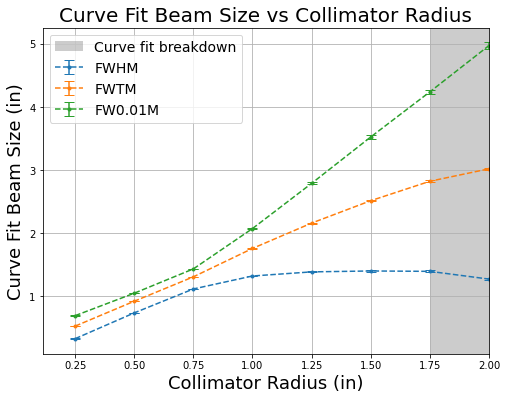

In [187]:
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(radii, np.array(fwhmList) / 25.4, fmt='o--', yerr=np.array(efwhmList) / 25.4, label='FWHM', ms=3, capsize=5)
ax.errorbar(radii, np.array(fwtmList) / 25.4, fmt='o--', yerr=np.array(efwtmList) / 25.4, label='FWTM', ms=3, capsize=5)
ax.errorbar(radii, np.array(fw100mList) / 25.4, fmt='o--', yerr=np.array(efw100mList) / 25.4, label='FW0.01M', ms=3, capsize=5)

ax.set_xlabel("Collimator Radius (in)", fontsize=18)
ax.set_ylabel("Curve Fit Beam Size (in)", fontsize=18)
ax.set_title("Curve Fit Beam Size vs Collimator Radius", fontsize=20)

ax.axvspan(1.75, 3, alpha=0.4, facecolor='gray', label='Curve fit breakdown')

plt.xlim(right=max(radii))

ax.grid()
ax.legend(fontsize=14)

plt.show()